# Tree-based Predicting Models

**Load necessary packages**

General packages

In [4]:
import pandas as pd
import numpy as np
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold, train_test_split, cross_val_score
import sklearn.model_selection as skm
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

import matplotlib.pyplot as plt
from matplotlib.pyplot import subplots

Tree-based methods packages

In [6]:
from sklearn.tree import (DecisionTreeClassifier as DTC,
                          DecisionTreeRegressor as DTR,
                          plot_tree,
                          export_text)
from sklearn.metrics import (accuracy_score,
                             log_loss)
from sklearn.ensemble import \
     (RandomForestClassifier as RFC,
      GradientBoostingClassifier as GBC)

In [7]:
import warnings

warnings.filterwarnings('ignore')

# Preprocessing 

## 1. Load data

In [10]:
raw = pd.read_csv("training.csv")
raw

,query_id,url_id,query_length,is_homepage,sig1,sig2,sig3,sig4,sig5,sig6,sig7,sig8,relevance,id
0,4631,28624,2,1,0.09,0.15,1288,352,376,13,0.46,0.35,0,4631.286240
1,4631,28625,2,1,0.20,0.35,4662,337,666,28,0.43,0.27,1,4631.286250
2,4631,28626,2,1,0.36,0.49,1121,385,270,15,0.34,0.20,1,4631.286260
3,4631,28627,2,1,0.21,0.45,2925,478,640,14,0.44,0.33,1,4631.286270
4,4631,28628,2,1,0.25,0.42,1328,429,412,27,0.40,0.57,1,4631.286280
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
80041,17038,102812,1,0,0.13,0.29,10,7,10,0,0.25,0.79,0,17038.102812
80042,17038,102813,1,0,0.12,0.20,121,0,46,1,0.30,0.50,0,17038.102813
80043,17038,102814,1,0,0.04,0.37,179,15,92,0,0.32,0.42,0,17038.102814
80044,17038,102815,1,0,0.22,0.50,643,223,114,10,0.32,0.86,1,17038.102815


## 2. Exploratory data analysis

**Check if there are missing data.**

In [13]:
missing_values = raw.isnull().sum()
missing_values
# raw = raw.dropna()

query_id        0
url_id          0
query_length    0
is_homepage     0
sig1            0
sig2            0
sig3            0
sig4            0
sig5            0
sig6            0
sig7            0
sig8            0
relevance       0
id              0
dtype: int64

No missing data.

**Check duplicates**

In [16]:
duplicates = raw.duplicated()
num_duplicates = duplicates.sum()
num_duplicates
# raw = raw.drop_duplicates()

0

No duplicates

## 3. Declare predictors and target variable.

In [19]:
X = raw.drop(['relevance', 'query_id', 'url_id', 'id'], axis=1)
y = raw['relevance']

## * Transformation

square root transformation

**Apply square root transformation to potentially reduce skewness or stabilize variance in features**

In [23]:
X_sqrt = X.apply(lambda x: np.sqrt(x.clip(lower=0)) if np.issubdtype(x.dtype, np.number) else x)

## 4. Scale the predictors

In [25]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_sqrt)
X_scaled = pd.DataFrame(X_scaled, columns = X.columns)
X_scaled.describe()

,query_length,is_homepage,sig1,sig2,sig3,sig4,sig5,sig6,sig7,sig8
count,8.004600e+04,8.004600e+04,8.004600e+04,8.004600e+04,8.004600e+04,8.004600e+04,8.004600e+04,8.004600e+04,8.004600e+04,8.004600e+04
mean,-1.691317e-14,-3.245814e-15,-2.489584e-15,-1.918258e-16,-7.834319e-16,-1.185814e-15,-1.314396e-15,-2.759616e-15,7.414691e-16,9.696913e-16
std,1.000006e+00,1.000006e+00,1.000006e+00,1.000006e+00,1.000006e+00,1.000006e+00,1.000006e+00,1.000006e+00,1.000006e+00,1.000006e+00
min,-1.248701e+00,-6.065367e-01,-2.191340e+00,-3.389215e+00,-6.902557e-01,-8.840368e-01,-7.682476e-01,-4.152870e-01,-4.130350e+00,-3.477810e+00
25%,-3.034569e-01,-6.065367e-01,-5.997821e-01,-6.400329e-01,-5.362739e-01,-6.440394e-01,-5.982915e-01,-4.152870e-01,-6.037433e-01,-6.408416e-01
50%,-3.034569e-01,-6.065367e-01,-1.200951e-02,1.088939e-01,-3.342227e-01,-1.574085e-01,-3.382888e-01,-4.152870e-01,5.591334e-02,9.520157e-02
75%,4.218545e-01,1.648705e+00,5.653193e-01,7.671577e-01,1.880519e-01,3.069165e-01,2.169119e-01,-7.467461e-03,7.423576e-01,7.366845e-01
max,6.151074e+00,1.648705e+00,3.435667e+00,2.174221e+00,1.361960e+01,3.894334e+01,1.088262e+01,1.699484e+01,2.922864e+00,1.629820e+00


## 5. Visualize Attributes and Relationships by combination of pairplots and heatmaps

**Pairplots**

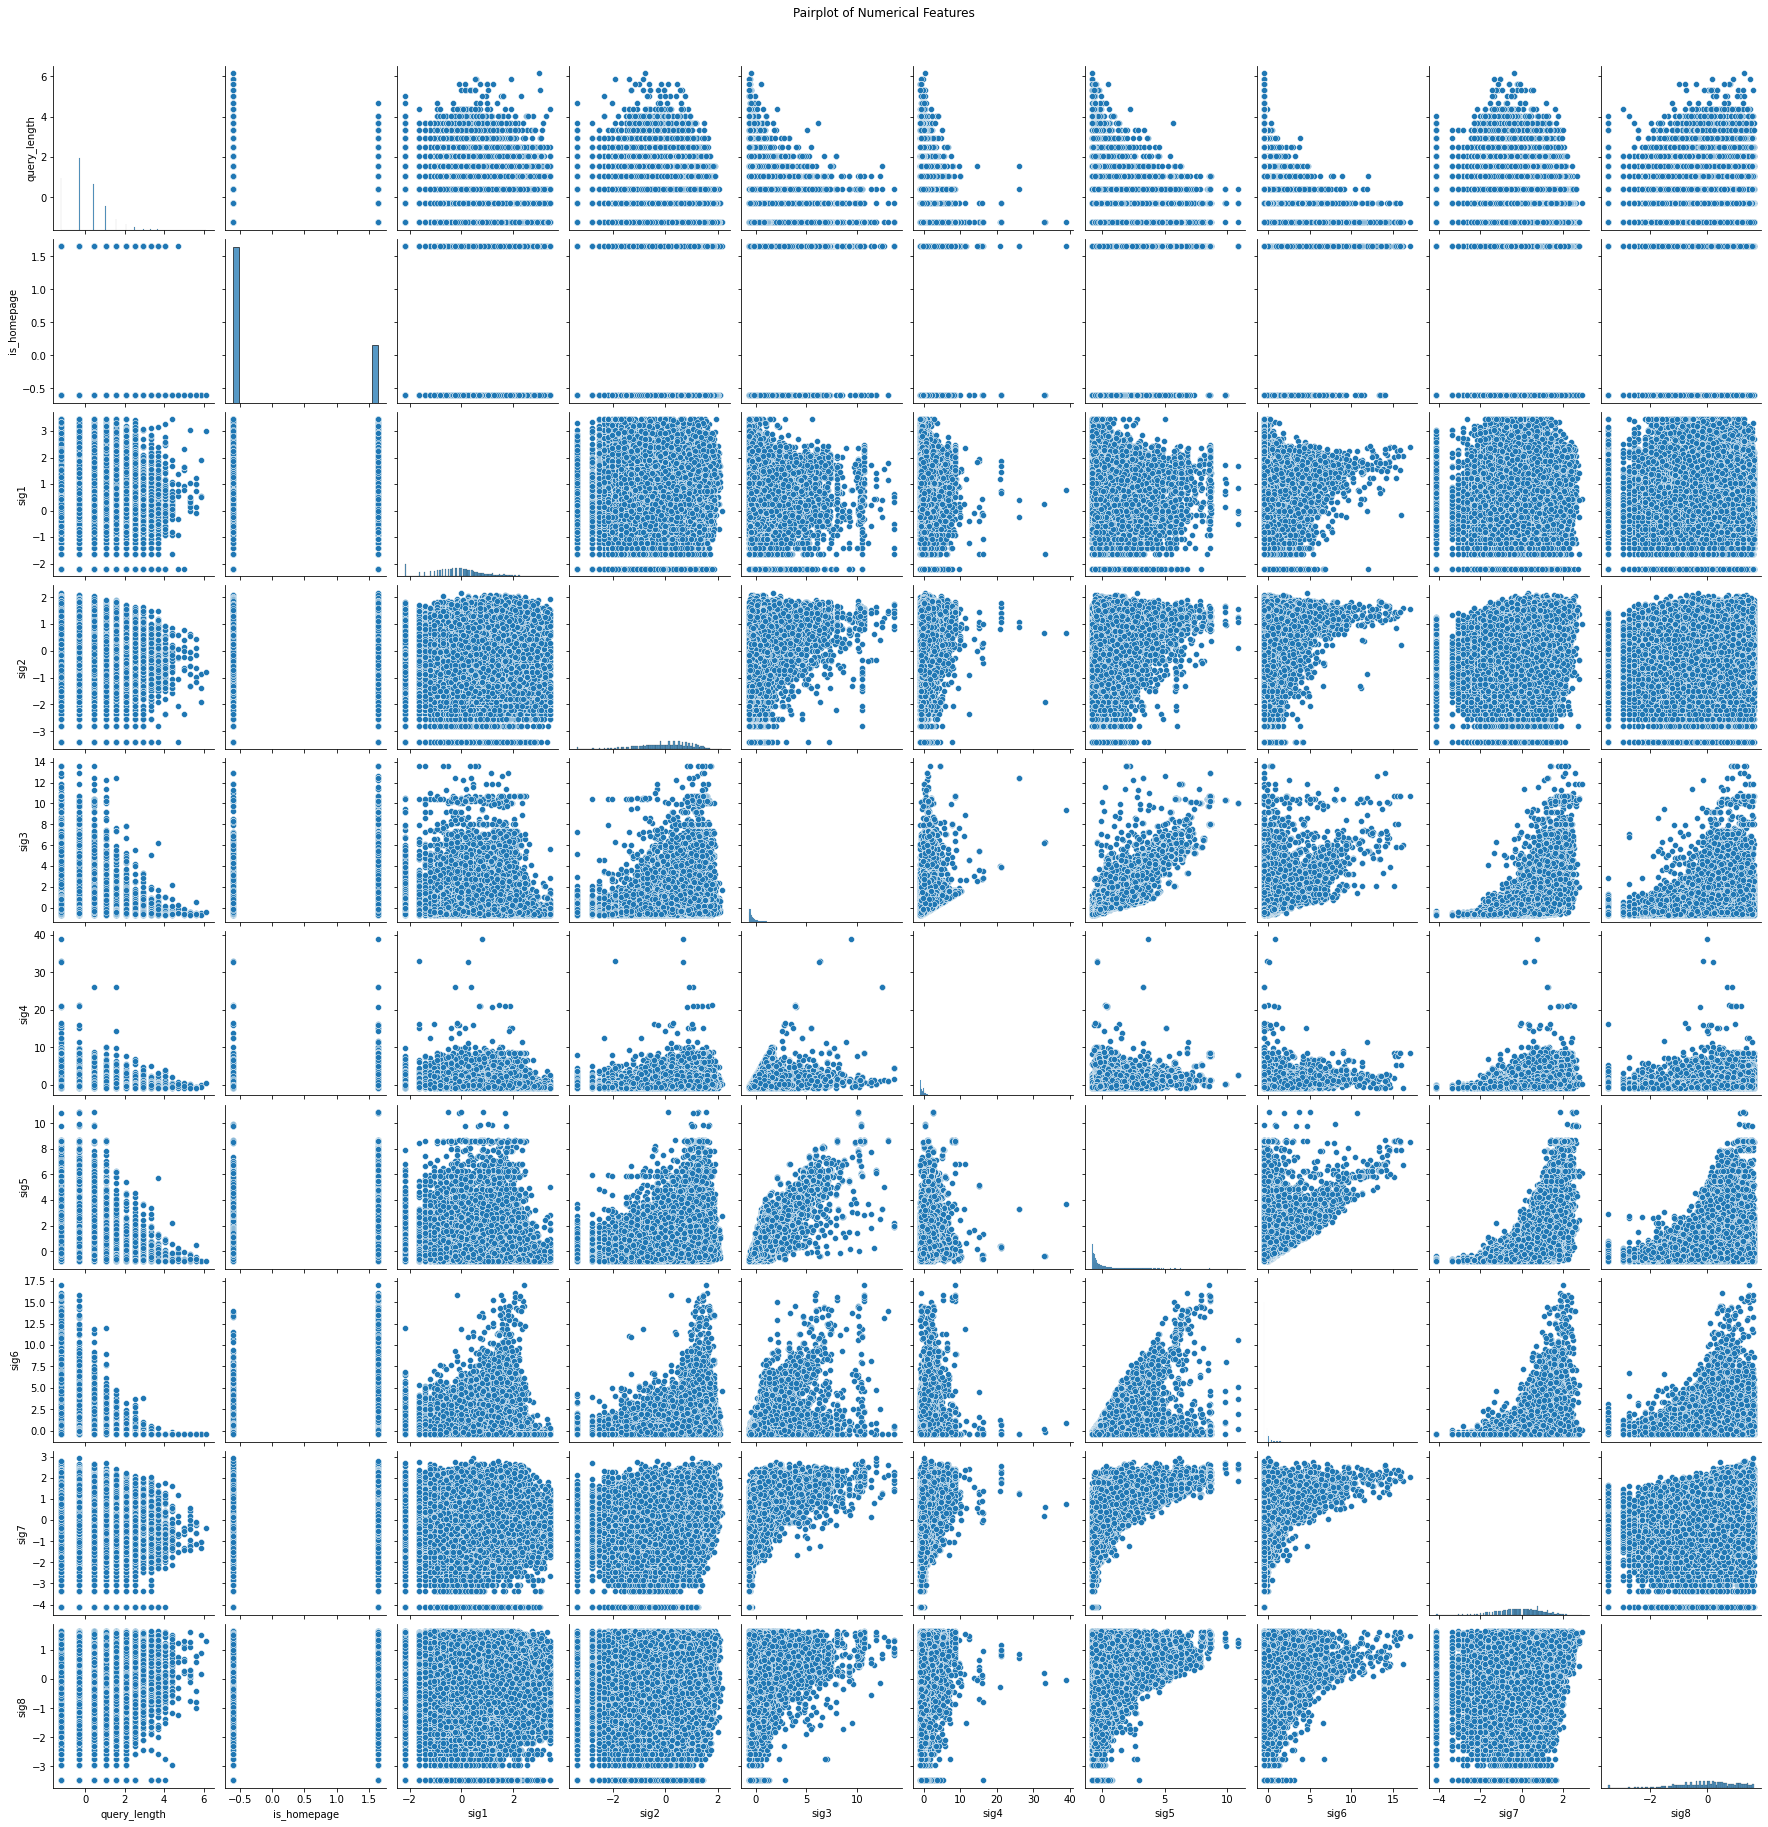

In [28]:
sns.pairplot(X_scaled)
plt.suptitle('Pairplot of Numerical Features', y=1.02)
plt.show()

**Heat map for correlation**

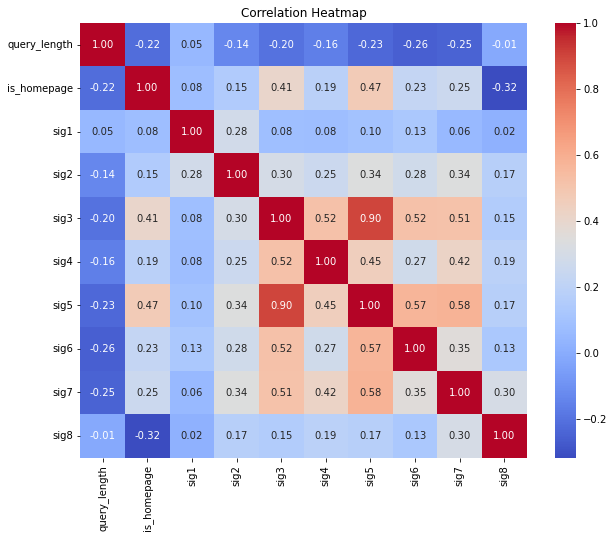

In [30]:
plt.figure(figsize=(10, 8))
sns.heatmap(X_scaled.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap')
plt.show()

# Model Fitting

## I. Decision Tree

**Split the data into training and testing sets (80% training set and 20% test set)**

In [34]:
#X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=666)

### 1. Unpruned Decision Tree

**Initialize and fit the Decision Tree Classifier**

In [37]:
#dtc = DTC(random_state=666)
#dtc.fit(X_train, y_train)

**Predict on the test set**

In [39]:
#y_pred = dtc.predict(X_test)

**Evaluate the model**

In [41]:
#print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

In [42]:
#print("Classification Report:\n", classification_report(y_test, y_pred))

In [43]:
#print("Accuracy Score:", accuracy_score(y_test, y_pred))

**Feature importance plot**

In [45]:
#importances = rf_model.feature_importances_
#indices = np.argsort(importances)[::-1]

#plt.figure(figsize=(12, 6))
#plt.title("Feature Importances")
#plt.bar(range(X_train.shape[1]), importances[indices], align="center")
#plt.xticks(range(X_train.shape[1]), X_scaled.columns[indices], rotation=90)
#plt.show()

### 2. Pruned Decision Tree

Then, we use cross-validation to prune the tree on the training set

**Cross-validation to find the optimal ccp_alpha**

Obtain the path with ccp_alphas

In [50]:
#clf = DTC(random_state=666)
#path = clf.cost_complexity_pruning_path(X_train, y_train)
#ccp_alphas = path.ccp_alphas

Perform 5-fold cross-validation for each ccp_alpha to find the best one

In [52]:
#cv_scores = []
#for ccp_alpha in ccp_alphas:
#    clf = DTC(random_state=666, ccp_alpha=ccp_alpha)
#    scores = cross_val_score(clf, X_train, y_train, cv=5)
#    cv_scores.append(scores.mean())

Find the best ccp_alpha with the highest cross-validation score

In [54]:
#optimal_ccp_alpha = ccp_alphas[np.argmax(cv_scores)]
#optimal_ccp_alpha

Plot cross-validation scores against ccp_alpha to visualize

In [56]:
#plt.figure(figsize=(8, 6))
#plt.plot(ccp_alphas, cv_scores, marker='o', drawstyle="steps-post")
#plt.xlabel('ccp_alpha')
#plt.ylabel('Cross-Validation Accuracy')
#plt.title('Cross-Validation Accuracy vs ccp_alpha')
#plt.show()

**Prune the tree with the optimal ccp_alpha**

In [58]:
#pruned_clf = DTC(random_state=666, ccp_alpha=optimal_ccp_alpha)
#pruned_clf.fit(X_train, y_train)

**Pridict the pruned tree on the test set**

In [60]:
#y_pred_pruned = pruned_clf.predict(X_test)

**Evaluate the pruned tree on the test set**

In [62]:
#print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_pruned))

In [63]:
#print("Classification Report:\n", classification_report(y_test, y_pred_pruned))

In [64]:
#print("Accuracy Score:", accuracy_score(y_test, y_pred_pruned))

**Feature importance plot**

In [66]:
#importances = pruned_clf.feature_importances_
#indices = np.argsort(importances)[::-1]

#plt.figure(figsize=(12, 6))
#plt.title("Feature Importances")
#plt.bar(range(X_train.shape[1]), importances[indices], align="center")
#plt.xticks(range(X_train.shape[1]), X_scaled.columns[indices], rotation=90)
#plt.xlabel('Feature')
#plt.ylabel('Importance')
#plt.show()

**Predict the classification for the test data**

In [68]:
#test_data = pd.read_csv("test.csv")
#X_true_test = test_data.drop(['query_id', 'url_id', 'id'], axis=1, errors='ignore')
#X_true_test_scaled = scaler.transform(X_true_test)
#predictions = pruned_clf.predict(X_true_test_scaled)
#results = pd.DataFrame({
#    'prediction': predictions,
#    'id': test_data['id']
#})

#results.to_csv("pruned_tree_predictions.csv", index=False)

## II. Random Forest

**Split the data into training and test sets**

In [71]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=666)

**Train the Random Forest model**

In [73]:
rfc = RFC(random_state=666)
rfc.fit(X_train, y_train)

RandomForestClassifier(random_state=666)

**Predict the Random Forest on the test set**

In [75]:
y_pred = rfc.predict(X_test)

**Evaluate the model**

In [77]:
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy on test set: {accuracy:.4f}")

Accuracy on test set: 0.6508


In [78]:
print("Classification report:\n", classification_report(y_test, y_pred))

Classification report:
               precision    recall  f1-score   support

           0       0.66      0.78      0.71      8964
           1       0.63      0.49      0.55      7046

    accuracy                           0.65     16010
   macro avg       0.65      0.63      0.63     16010
weighted avg       0.65      0.65      0.64     16010



In [79]:
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

Confusion Matrix:
 [[6955 2009]
 [3582 3464]]


**Feature Importance Visualization**

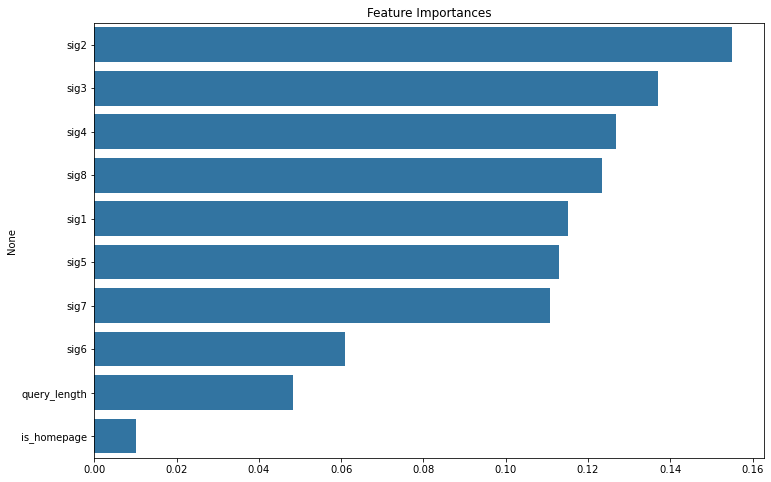

In [81]:
plt.figure(figsize=(12, 8))
importances = rfc.feature_importances_
indices = np.argsort(importances)[::-1]
sns.barplot(x=importances[indices], y=X_train.columns[indices])
plt.title('Feature Importances')
plt.show()

**Predict the classification for the test data**

In [83]:
test_data = pd.read_csv("test.csv")
X_true_test = test_data.drop(['query_id', 'url_id', 'id'], axis=1, errors='ignore')
X_true_test_sqrt_transformed = np.log1p(X_true_test)
X_true_test_scaled = scaler.transform(X_true_test_sqrt_transformed)
predictions = rfc.predict(X_true_test_scaled)
results = pd.DataFrame({
    'prediction': predictions,
    'id': test_data['id']
})

results.to_csv("RandomForest_sqrt.trans_predictions.csv", index=False)

## III. Boosting

**Split the data into training and test sets**

In [86]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=666)

**Train the Gradient Boosting model**

In [88]:
gbc = GBC(random_state=666)
gbc.fit(X_train, y_train)

GradientBoostingClassifier(random_state=666)

**Predict the Boosting on the test set**

In [90]:
y_pred = gbc.predict(X_test)

**Evaluate the model**

In [92]:
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy on test set: {accuracy:.4f}")

Accuracy on test set: 0.6583


In [93]:
print("Classification report:\n", classification_report(y_test, y_pred))

Classification report:
               precision    recall  f1-score   support

           0       0.66      0.80      0.72      8964
           1       0.65      0.48      0.55      7046

    accuracy                           0.66     16010
   macro avg       0.66      0.64      0.64     16010
weighted avg       0.66      0.66      0.65     16010



In [94]:
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

Confusion Matrix:
 [[7146 1818]
 [3653 3393]]


**Feature Importance Visualization**

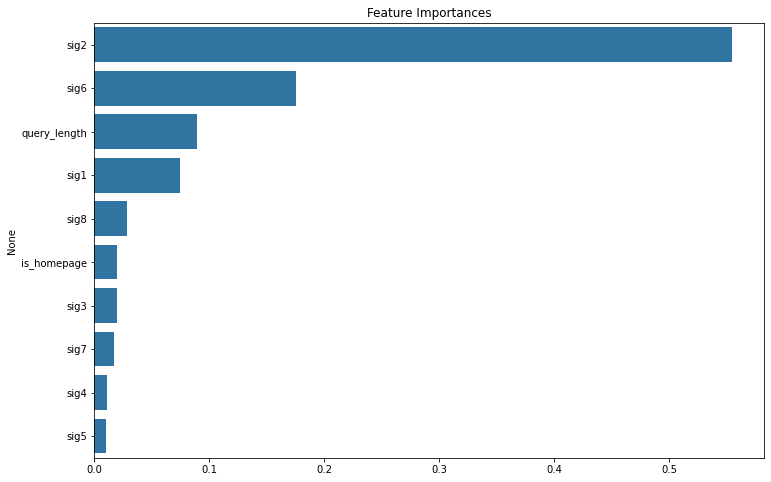

In [96]:
plt.figure(figsize=(12, 8))
importances = gbc.feature_importances_
indices = np.argsort(importances)[::-1]
sns.barplot(x=importances[indices], y=X_train.columns[indices])
plt.title('Feature Importances')
plt.show()

**Predict the classification for the test data**

In [98]:
test_data = pd.read_csv("test.csv")
X_true_test = test_data.drop(['query_id', 'url_id', 'id'], axis=1, errors='ignore')
X_true_test_sqrt_transformed = np.log1p(X_true_test)
X_true_test_scaled = scaler.transform(X_true_test_sqrt_transformed)
predictions = gbc.predict(X_true_test_scaled)
results = pd.DataFrame({
    'prediction': predictions,
    'id': test_data['id']
})

results.to_csv("Boosting_sqrt.trans_predictions.csv", index=False)